# Exploring the Chess Evaluations Dataset

## By Davin Jeong


In this notebook, we'll be analyzing the [Chess Evaluations dataset by Ronak Badhe](https://www.kaggle.com/ronakbadhe/chess-evaluations) on Kaggle. It contains around 16 million chess positions with their associated Stockfish evaluation. We plan on using "chessData," which contains about 12 million chess positions evaluated with StockFish 11 at depth 22, to create a static evaluation function for CarissaBot. We chose to not use "randomEvals" or "tactic_evals" for now, as we'd like our bot to have a general sense of the game before we improve its performance, and those evaluations are also created at a lower search depth (mixing data from different evaluation metrics might pose a problem, which we don't want to encounter yet). 

### Sources:
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
- https://github.com/niklasf/python-chess
- https://www.pythonprogramming.in/find-mean-median-and-mode-of-dataframe-in-pandas.html
- https://python-chess.readthedocs.io/en/latest/
- PyData_Stack_Lab.ipynb
- https://tynedalechess.wordpress.com/2017/11/05/fen-strings-explained/

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import sklearn as skt

%matplotlib inline

plt.style.use("fivethirtyeight")

### Load Dataset

In [2]:
df = pd.read_csv('ChessEvaluations/chessData.csv')

In [3]:
df.describe()

,FEN,Evaluation
count,12958035,12958035
unique,12954834,13545
top,r2qkbnr/pp3ppp/2bpp3/8/3QP3/2N2N2/PPP2PPP/R1B2...,0
freq,3,1261356


### Feature Analysis

In [4]:
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [5]:
print(df.shape)
print(df.dtypes)
print(type(df.values[0][0]), type(df.values[0][1]))

(12958035, 2)
FEN           object
Evaluation    object
dtype: object
<class 'str'> <class 'str'>


This dataset has 12,958,035 samples, each with 2 features: a FEN string describing a chess position and its associated evaluation. 

According to [Tnyedale Chess Club's website](https://tynedalechess.wordpress.com/2017/11/05/fen-strings-explained/), a FEN string (also known as Forsyth-Edwards Notation) comprises of the following fields, separated by spaces:
1) Piece placement from white's perspective. They are described in order of rank (row) top to bottom and within each rank, in order of file (column) left to right. Each piece is identified following the Standard Algebraic Notation (SAN), where (pawn = “P”, knight = “N”, bishop = “B”, rook = “R”, queen = “Q” and king = “K”). White pieces are uppercased, while black pieces are undercased. Contiguous blocks of empty spaces are notated by a digit representing their size. "/" separates ranks.

2) Turn to move: "w" means it's White's turn, "b" means its Black's turn

3) Castling Availability: A string containing "-" for neither side can castle, or a combination of the following: “K” (White can castle kingside), “Q” (White can castle queenside), “k” (Black can castle kingside), and/or “q” (Black can castle queenside).

4) En-passant: If an en-passant capture is possible, this contains the square that the capturing pawn will end up on. Otherwise, it's "-". 

5) Halfmove clock: The counter starts at 0 and incrememnts for every non-pawn and non-capture move. If a pawn move or a capture is made, the counter resets.

6) Fullmove clock: This counts the number of complete moves played. It starts at 1, and increments by one everytime white makes a move and black replies. 

Without getting into the nuances of chess, Stockfish's evaluation is a float. Positive values indicate that white has the advantage, whereas negative values indicate that black has the advantage. "0" means that the players are drawn. Greater magnitudes signify a greater inequality in terms of position. For instance, an evaluation of "+100" means that white is significantly in favor. 

### Visualizing FEN Strings

We can use the python-chess library to visualize some of our inputs:

In [6]:
import chess

In [35]:
sample_row = df.sample().to_numpy()
sample_FEN = sample_row[0][0]
sample_EVAL = sample_row[0][1]

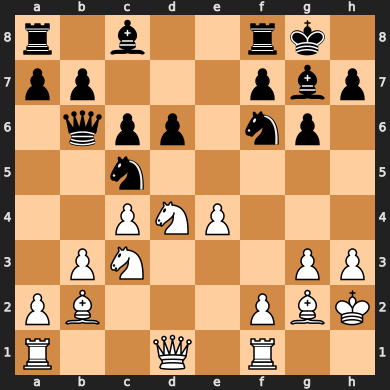

In [37]:
chess.Board(sample_FEN)

### Histograms of Evaluation
We can also use matplotlib to look at the overall distribution of evaluations!

In [62]:
white_checkmates = black_checkmates = 0

def convert_evaluation_to_float(evaluation):
    global white_checkmates
    global black_checkmates
    try: # Direct Evaluation
        result = float(evaluation)
        return result
    except: # Forced checkmates
        if '+' in evaluation:
            white_checkmates+=1
            return 20000
        elif '-' in evaluation:
            black_checkmates+=1
            return -20000
        else:
            print(evaluation)

In [63]:
df['Evaluation'].apply(convert_evaluation_to_float).min()

-20000.0

In [64]:
df['Evaluation'].apply(convert_evaluation_to_float).max()

20000.0

{'whiskers': [<matplotlib.lines.Line2D at 0x21fd948ebc8>,
 'caps': [<matplotlib.lines.Line2D at 0x21fd945a3c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x21fd948e308>],
 'medians': [<matplotlib.lines.Line2D at 0x21fd94715c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x21fd945af88>],
 'means': []}

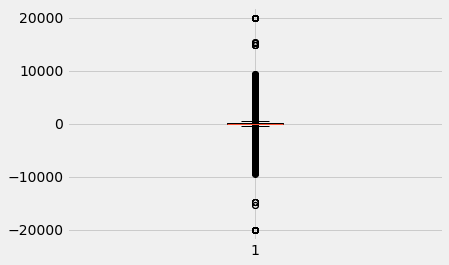

In [66]:
plt.boxplot(df['Evaluation'].apply(convert_evaluation_to_float))

In [67]:
print(white_checkmates, black_checkmates)

436584 324036


Looking at this box and whiskers plot, we can identify many things. 

First of all, the majority of our positions have an evaluation close to zero, signifying that the game is quite close. This makes sense—it seems intuitive that positions will drag out near the middle, whereas vastly uneven positions will end really quick. 

We can also identify a symmetry in our plot, meaning that we have a good distribution of positions representing white and black. I represented possible forced checkmates with a magnitutude of 20,000. Based on my counters, it seems that the white and black positions are clearly distinct, despite the nice symmetry. I wonder if this means that we can possible double the size of our dataset by flipping colors and turns.

One possible source of research is to investigate the three major groups on either side of the x-axis: from 0 to 10,000, around 15,000, and at 20,000. The latter, as I mentioned above, are forced checkmates. I won't do this here, but it seems like a possibly fruitful avenue for further data analaysis, to improve the knowledge of our chess bot.